# Trump For Stock Prediction
### Predicting Stock Prices from the Sentiment of Donald Trump's Tweets
Adam Haile, Alhagie Boye, Eric Van Zant

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from scipy.stats import linregress
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hailea\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **Research Question**

Does the sentiment of Donald Trump's tweets from 2010 to 2021 correlate with the fluctuations in the S&P 500 stock index during the same period?

### Objectives
1. Obtain the sentiment of Trump’s tweets utilizing TextBlob. 
2. Correlate the sentiment of Trump’s tweets to the fluctuation of stock. 
3. Develop a model capable of predicting stock prices based on Trump’s tweets.

### **Hypothesis**

**Null Hypothesis:** There is no correlation between the sentiment of Trump’s tweets and the S&P 500 stock price.  

**Alternative Hypothesis:** There is a correlation between the sentiment of Trump’s tweets and the S&P 500 stock price.    

### **Dataset**

* **Trumps Legacy Dataset**: https://www.kaggle.com/datasets/zusmani/trumps-legacy
* **SP500 Dataset**: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/
* **SP500 Companies**: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/?select=sp500_companies.csv

**Trump's Legacy**

* This dataset contains 56,571 tweets from Donald Trump's Twitter account. The dataset was collected from the Trump Twitter Archive. The dataset contains the following columns: id, date, time, source, text, retweets, favorites, is_retweet, and id_str. The dataset was collected from January 20, 2017, to January 8, 2021.

In [50]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
trump.head()

,id,text,device,favorites,retweets,date
0,98455000000000000,Republicans and Democrats have both created ou...,TweetDeck,49,255,8/2/2011 18:07
1,1234650000000000000,I was thrilled to be back in the Great city of...,Twitter for iPhone,73748,17404,3/3/2020 1:34
2,1218010000000000000,RT @CBS_Herridge: READ: Letter to surveillance...,Twitter for iPhone,0,7396,1/17/2020 3:22
3,1304880000000000000,The Unsolicited Mail In Ballot Scam is a major...,Twitter for iPhone,80527,23502,9/12/2020 20:10
4,1218160000000000000,RT @MZHemingway: Very friendly telling of even...,Twitter for iPhone,0,9081,1/17/2020 13:13


**SP500 Stocks**

* This dataset contains the daily closing price of the S&P 500 index from January 20, 2017, to January 8, 2021. The dataset contains the following columns: date, close, high, low, open, and volume.

In [51]:
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')
stock.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,53.295406,83.019997,83.449997,82.669998,83.089996,3043700.0
1,2010-01-05,MMM,52.961571,82.500000,83.230003,81.699997,82.800003,2847000.0
2,2010-01-06,MMM,53.712673,83.669998,84.599998,83.510002,83.879997,5268500.0
3,2010-01-07,MMM,53.751186,83.730003,83.760002,82.120003,83.320000,4470100.0
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0


**SP500 Companies**

* This dataset contains the list of companies in the S&P 500 index. The dataset contains the following columns: Symbol, Security, SEC filings, GICS Sector, GICS Sub-Industry, Headquarters Location, Date first added, CIK, Founded. It contains 505 rows and 9 columns.

In [52]:
spCompanies = pd.read_csv('sp500_daily/sp500_companies.csv')
spCompanies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,407.72,3029538963456,1.184270e+11,0.176,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.064540
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,181.42,2801469489152,1.301090e+11,0.021,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.059681
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,776.63,1941575041024,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,"NVIDIA Corporation provides graphics, and comp...",0.041363
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,173.16,1798682181632,8.551500e+10,0.139,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.038318
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,136.38,1702349766656,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.036266


### **Data Preprocessing**

The only data preprocessing needed for the stock data was to just sort by date rather than symbol. Other than this, the data is already decently well organized and maintained.

In [53]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

Data preprocessing for the Trump data occurred in a few steps. The first segment was processing the Trump data for sentiment analysis. This required first sorting the data based upon date (as it was not already sorted by this), to ensure it would be easier to work with down the line. From here, some NLP is applied to remove all links in the tweet text, and removing the word 'RT'. This is done for a few reasons:
- When sentiment analysis is applied on the tweet data with links, they tend to be inflated towards neutral, so removing links within text, or dropping rows of data which are exclusively just links, can reduce this inflation by about 2%

In [54]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]

# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

- The letters 'RT' also tend to be treated as neutral, so there can be some bias in the tweet by leaving these. The goal is to classify the sentiment, so even if a tweet is a retweet, it is still important to keep as it indicates the sentiment of Trump at the time, so we can get more accurate results by removing 'RT', and reduces the neutrality inflation by about 3%.

In [55]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]

trump['text'] = retweet_filtered['text'].apply(remove_links)
trump.dropna(subset=['text'], inplace=True)

Now that the Trump data has been preprocessed, we can begin to perform Sentiment Analysis on the tweet text.

### **Data Analysis and Visualization**

#### Stock Data Analysis
Stock data and market data analysis
  
A list of the symbols of the top 10 stocks with the highest market cap

In [56]:
top_10 = spCompanies.nlargest(10, 'Marketcap')['Symbol'].tolist()
print(top_10)

['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'LLY', 'TSLA']


Pie chart of the top 10 stocks with the highest market cap

[3029538963456, 2801469489152, 1941575041024, 1798682181632, 1702349766656, 1700641112064, 1233965416448, 892769468416, 719882223616, 643454926848]
['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'LLY', 'TSLA']


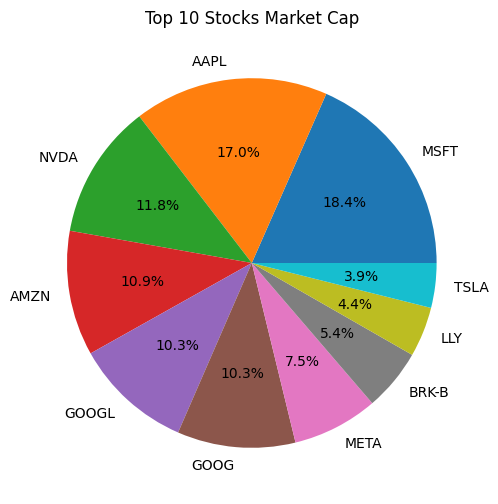

In [57]:
top_10_market_cap = spCompanies.nlargest(10, 'Marketcap')['Marketcap'].tolist()
top_10_stocks = spCompanies.nlargest(10, 'Marketcap')['Symbol'].tolist()
print(top_10_market_cap)
print(top_10_stocks)

plt.figure(figsize=(12, 6))
plt.pie(top_10_market_cap, labels=top_10_stocks, autopct='%1.1f%%')
plt.title('Top 10 Stocks Market Cap')
plt.show()

A line chart of the top 10 stocks with the highest market cap

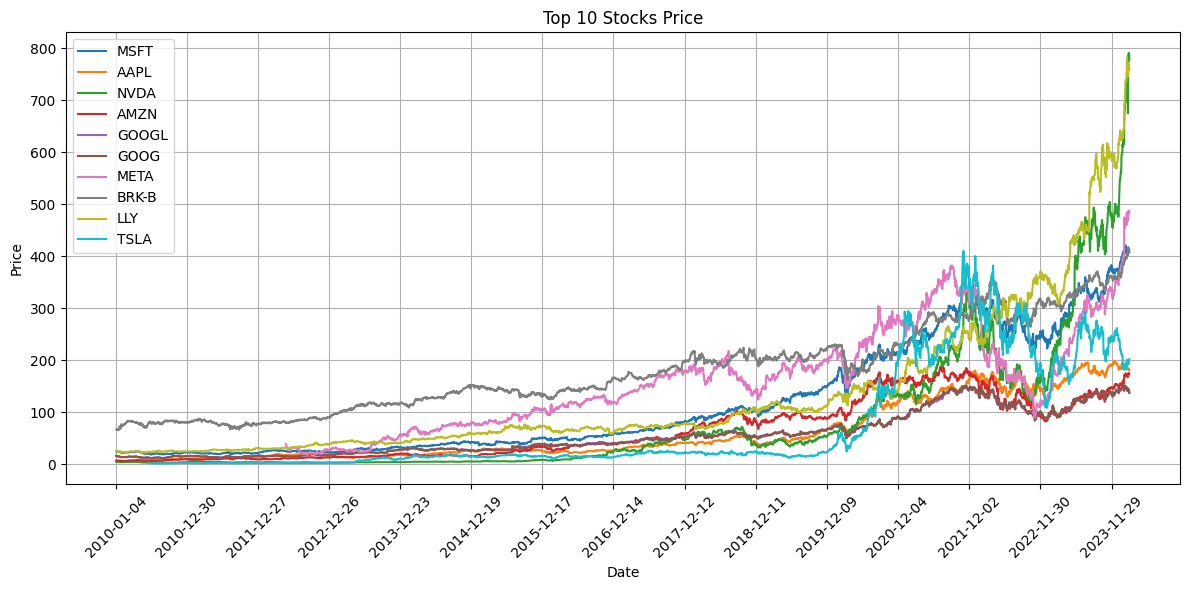

In [58]:
plt.figure(figsize=(12, 6))
for company in top_10:
    stock_data = stock[stock['Symbol'] == company]
    plt.plot(stock_data['Date'], stock_data['Adj Close'], label=company)  

plt.title('Top 10 Stocks Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(stock_data['Date'][::250], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A pie chart of the top 10 industries with the highest market cap

['Software - Infrastructure', 'Consumer Electronics', 'Semiconductors', 'Internet Retail', 'Internet Content & Information', 'Internet Content & Information', 'Internet Content & Information', 'Insurance - Diversified', 'Drug Manufacturers - General', 'Auto Manufacturers']
[3029538963456, 2801469489152, 1941575041024, 1798682181632, 1702349766656, 1700641112064, 1233965416448, 892769468416, 719882223616, 643454926848]


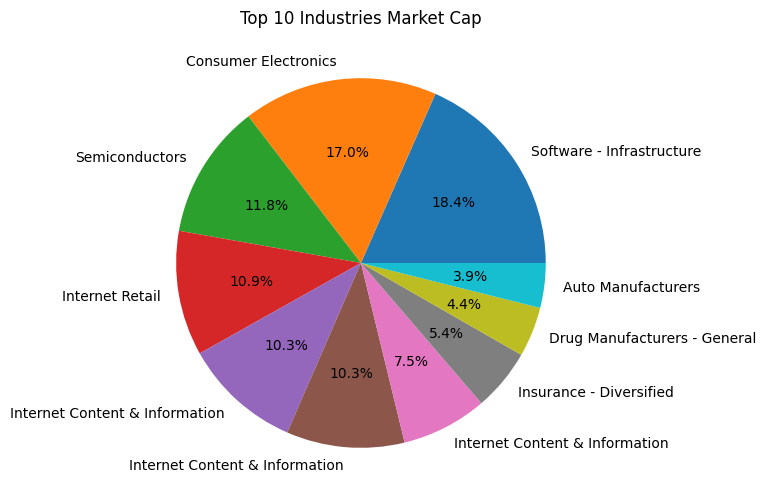

In [59]:
top_10_Insustries = spCompanies.nlargest(10, 'Marketcap')['Industry'].tolist()
print(top_10_Insustries)
print(top_10_market_cap)

plt.figure(figsize=(12, 6))
plt.pie(top_10_market_cap, labels=top_10_Insustries, autopct='%1.1f%%')
plt.title('Top 10 Industries Market Cap')
plt.show()

A bar chart of the average stock prices of the top 10 stocks with the highest market cap

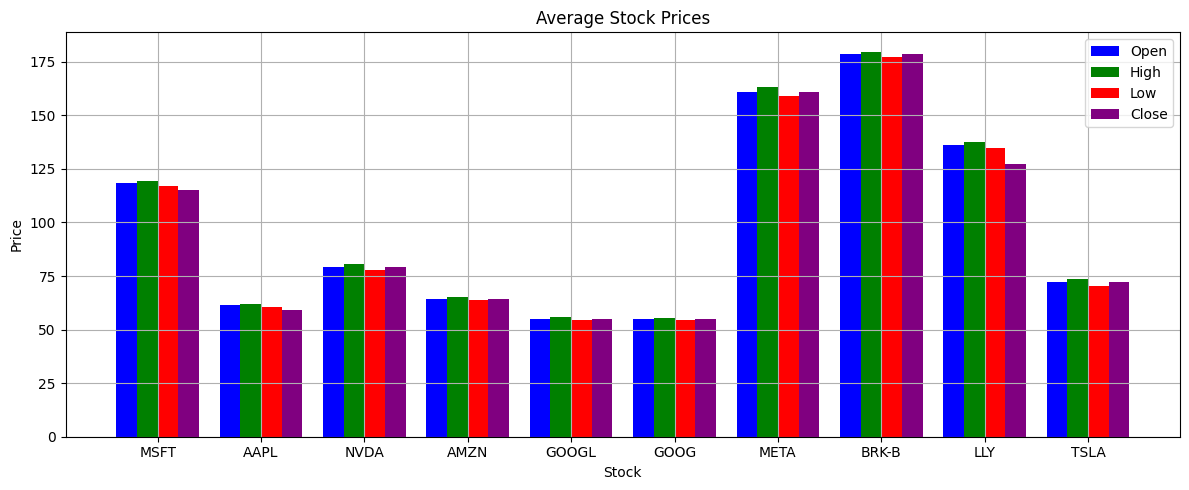

In [60]:
n = len(top_10)
x = np.arange(n)
width = 0.2

# colors for each type of price
colors = {'Open': 'blue', 'High': 'green', 'Low': 'red', 'Close': 'purple'}

plt.figure(figsize=(12, 5))

# For each stock, create a bar for 'Open', 'High', 'Low', and 'Close' prices
for i, company in enumerate(top_10):
    stock_data = stock[stock['Symbol'] == company]
    avg_open = stock_data['Open'].mean()
    avg_high = stock_data['High'].mean()
    avg_low = stock_data['Low'].mean()
    avg_close = stock_data['Adj Close'].mean()

    plt.bar(x[i] - width*1.5, avg_open, width, color=colors['Open'], label='Open' if i == 0 else "")
    plt.bar(x[i] - width/2, avg_high, width, color=colors['High'], label='High' if i == 0 else "")
    plt.bar(x[i] + width/2, avg_low, width, color=colors['Low'], label='Low' if i == 0 else "")
    plt.bar(x[i] + width*1.5, avg_close, width, color=colors['Close'], label='Close' if i == 0 else "")


plt.title('Average Stock Prices')
plt.xlabel("Stock")
plt.ylabel("Price")
plt.xticks(x, top_10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

STOCK PRICES(HIGH, LOW, OPEINING, ADJ CLOSING) OF EACH OF THE TOP 10 COMPANIES

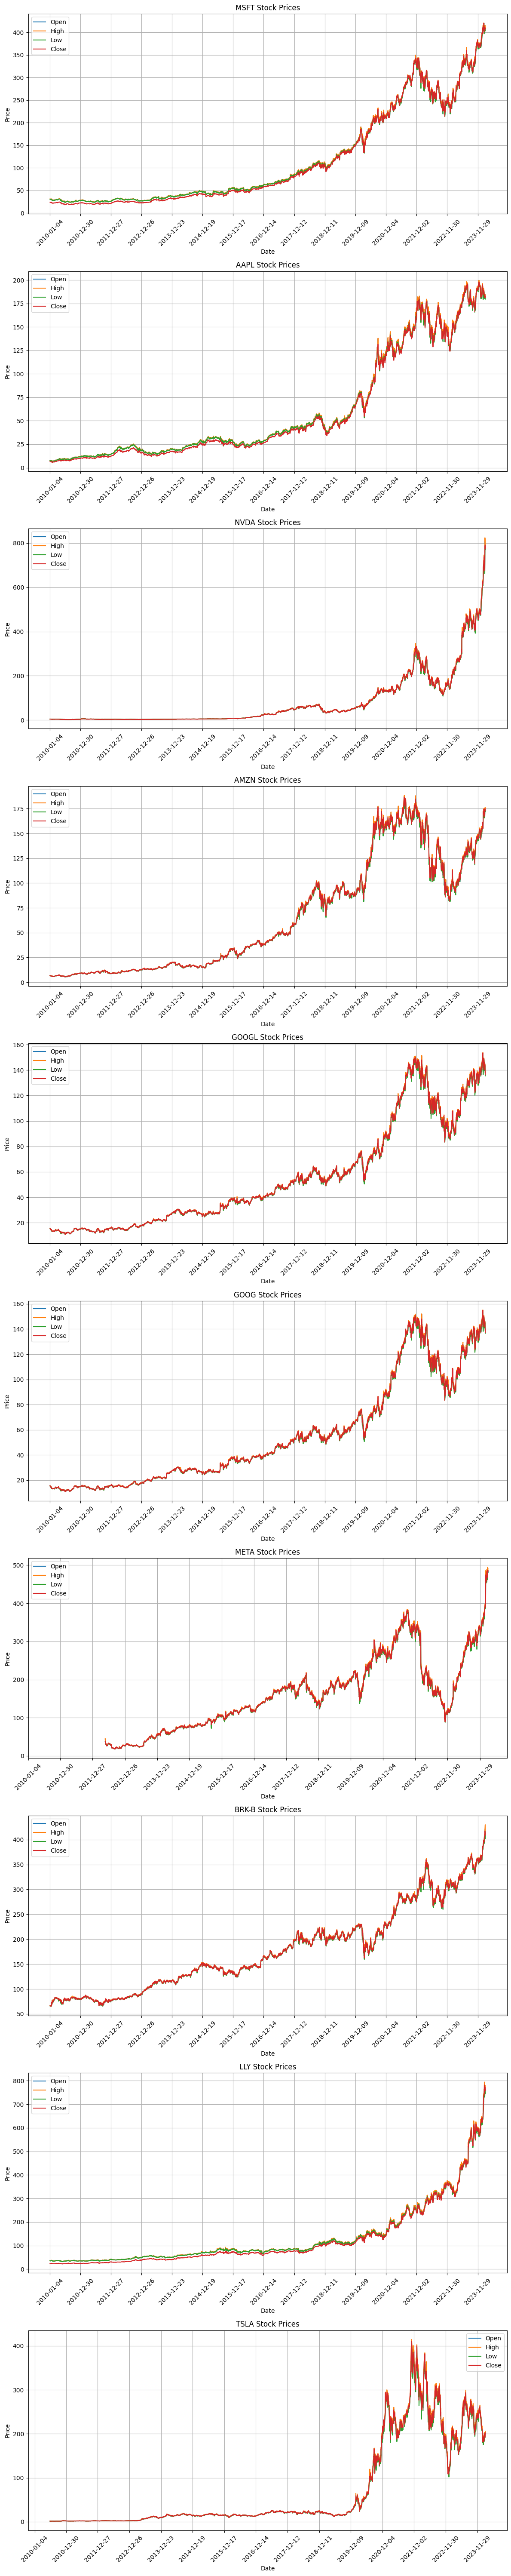

In [65]:
fig, axs = plt.subplots(len(top_10), 1, figsize=(12, 6*len(top_10)))

for ax, company in zip(axs, top_10):
    stock_data = stock[stock['Symbol'] == company]
    
    ax.plot(stock_data['Date'], stock_data['Open'], label='Open')
    ax.plot(stock_data['Date'], stock_data['High'], label='High')
    ax.plot(stock_data['Date'], stock_data['Low'], label='Low')
    ax.plot(stock_data['Date'], stock_data['Adj Close'], label='Close')
    
    ax.set_title(f'{company} Stock Prices')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.set_xticks(stock_data['Date'][::250])
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Let's first start off with analyizing the amount of tweets Trump has over 2010 to 2021.

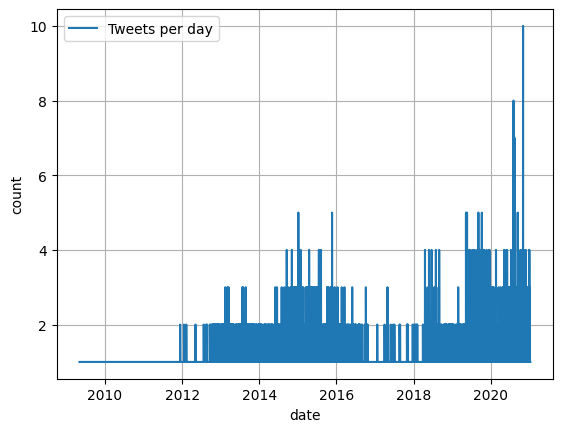

In [61]:
trump['date'] = pd.to_datetime(trump['date'])
tweets_per_day = trump['date'].value_counts().sort_index()
sns.lineplot(data=tweets_per_day, label='Tweets per day')
plt.grid()

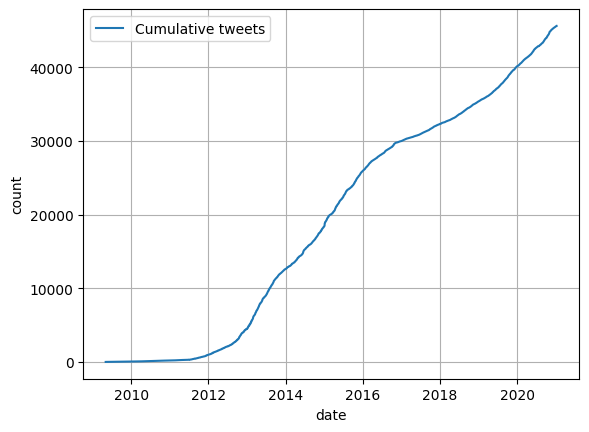

In [62]:
sum_tweets_per_day = tweets_per_day.cumsum()
sns.lineplot(data=sum_tweets_per_day, label='Cumulative tweets')
plt.grid()

We can see that the starting counts trend toward about 0 to 1 tweet per day, but over time have a trend towards increasing up to 2021. Some of the largest spikes in tweets came around the time of both the first and second election, and prior to when Trump was banned from Twitter.

Analyzing the favorites and retweets per day also shows a similar trend

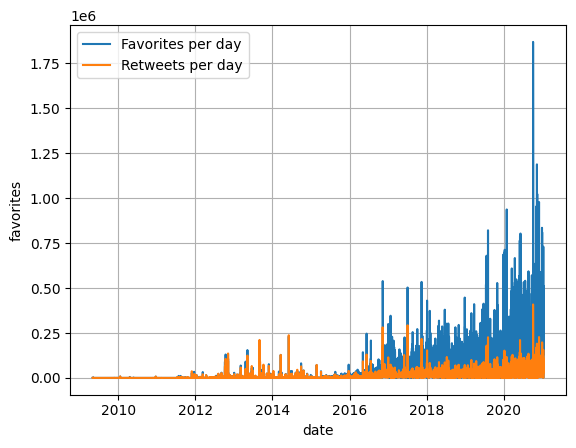

In [63]:
favorites_per_day = trump.groupby('date')['favorites'].sum()
retweets_per_day = trump.groupby('date')['retweets'].sum()
sns.lineplot(data=favorites_per_day, label='Favorites per day')
sns.lineplot(data=retweets_per_day, label='Retweets per day')
plt.grid()

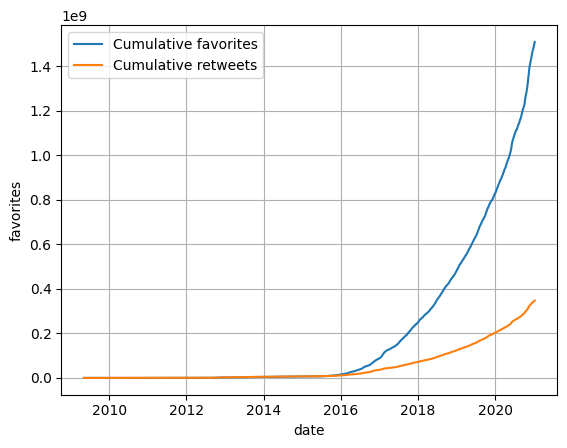

In [64]:
cum_favorites_per_day = favorites_per_day.cumsum()
cum_retweets_per_day = retweets_per_day.cumsum()
sns.lineplot(data=cum_favorites_per_day, label='Cumulative favorites')
sns.lineplot(data=cum_retweets_per_day, label='Cumulative retweets')
plt.grid()

For Sentiment Analysis, we used the Valence Aware Dictionary and sEntiment Reasoner (cjhutto), or VADER, model. We chose the VADER model because it has been tuned specifically for the sentiments of social media content. It is also a commonly used model for similar research (Kinyua J, et al.). To start, we must first compute the polarity of the tweets.

In [ ]:
sia = SentimentIntensityAnalyzer()

def get_polarity(text):
    return sia.polarity_scores(text)['compound']

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

KeyboardInterrupt: 

The polarity of the tweet gives us the emotional sentiment of the tweet. It is the only form of sentiment which VADER supports, however other models such as TextBlob support sentiments such as subjectivity (how opinionated is the sentiment), intent-based (what the user intends to do), and many others. We chose this particular form because it was the only one which VADER supports, but also it is one of the most commonly used metrics for tasks of a similar nature.
  
Once we have calculated the polarity, we can now create a new column which stores the cummulative polarity.

In [ ]:
trump['polarityCumulative'] = trump['polarity'].cumsum()

The cummulative polarity will be what we use for trend analysis. When polarity is computed, the value is scored between -1 and 1. Negative one indicates a highly negative emotion tweet (tends to use words like bad, awful, etc.). Positive one indicates a highly positive emotion tweet (contains words like good, great, etc). This value is a continuous value between -1 and 1, so a cummulative calculation would mean that there is a chance the polarity could go up or down equally at any given point.

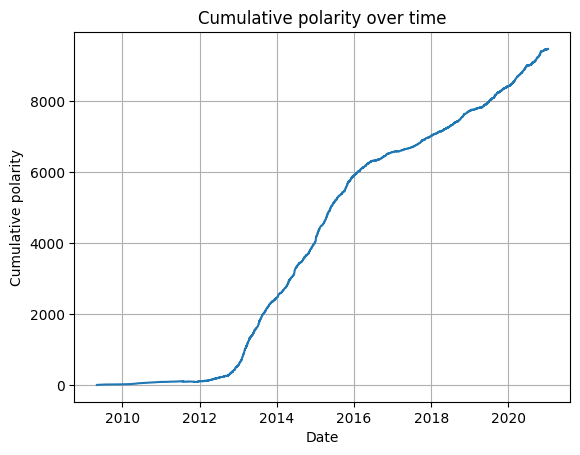

In [ ]:
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

Let's get an idea how much of the data is positive or negative. We're going to bin the polarity results based on the following criteria:
 - -1 to -0.6: Highly Negative
 - -0.6 to -0.2: Negative
 - -0.2 to 0.2: Neutral
 - 0.2 to 0.6: Positive
 - 0.6 to 1: Highly Positive

In [ ]:
trump['polarityBinned'] = pd.cut(trump['polarity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['highly negative', 'negative', 'neutral', 'positive', 'highly positive'])

polarityBinned
highly positive    14296
neutral            10422
positive           10349
negative            5574
highly negative     4985
Name: count, dtype: int64


<Axes: ylabel='count'>

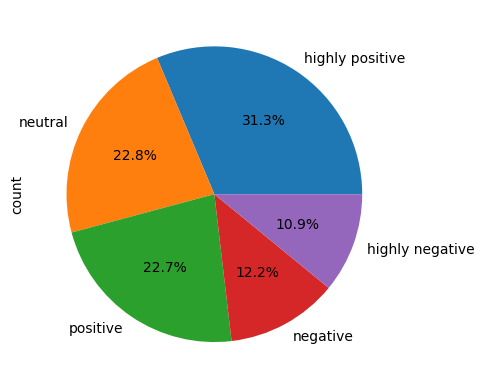

In [ ]:
polarity_counts = trump['polarityBinned'].value_counts()
print(trump['polarityBinned'].value_counts())
polarity_counts.plot.pie(autopct='%1.1f%%')

Thanks to our data preprocessing earlier, we have a decently balanced pie chart of each polarity.  
Additionally, our choice in model made a large difference. Let's take a look at how this chart would look had we have used TextBlob, which is not specialized for social media sentiment analysis.

textBlobPolarityBinned
neutral            23056
positive           12448
highly positive     5747
negative            3429
highly negative      729
Name: count, dtype: int64


<Axes: ylabel='count'>

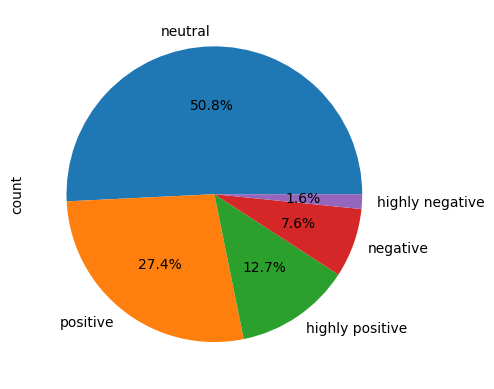

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_polarity)

trump['textBlobPolarity'] = vectorized_get_polarity(trump['text'])

trump['textBlobPolarityBinned'] = pd.cut(trump['textBlobPolarity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['highly negative', 'negative', 'neutral', 'positive', 'highly positive'])

polarity_counts = trump['textBlobPolarityBinned'].value_counts()
print(trump['textBlobPolarityBinned'].value_counts())
polarity_counts.plot.pie(autopct='%1.1f%%')

We can see that there is a much larger bias towards the neutral and positive categories, and the other ones don't even take up 25% of the pie chart. Using VADER will give us a more accurate and larger spread of results than TextBlob would.

We can also check out the spread of words with a word cloud, which will display a word larger if it is more frequently used.

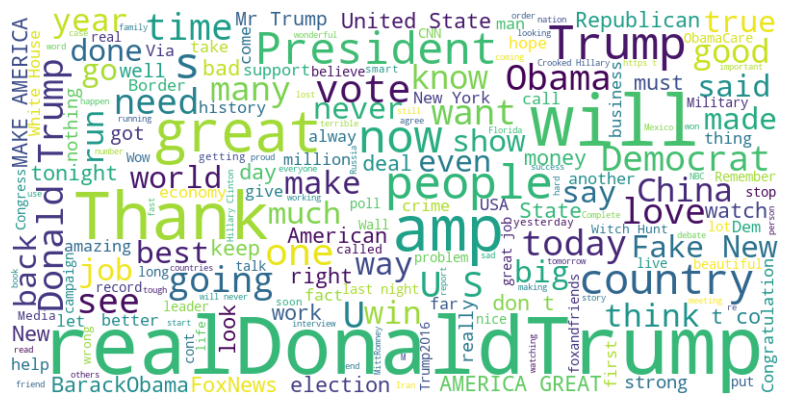

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(trump['text'].str.cat())
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Of course, the word realDonaldTrump shows up most frequently, as this text is always included if someone tags him and he retweets it (which happens quite frequently).

We can also check out some word clouds at different polarity levels.

Below is a word cloud of all Neutral tweets

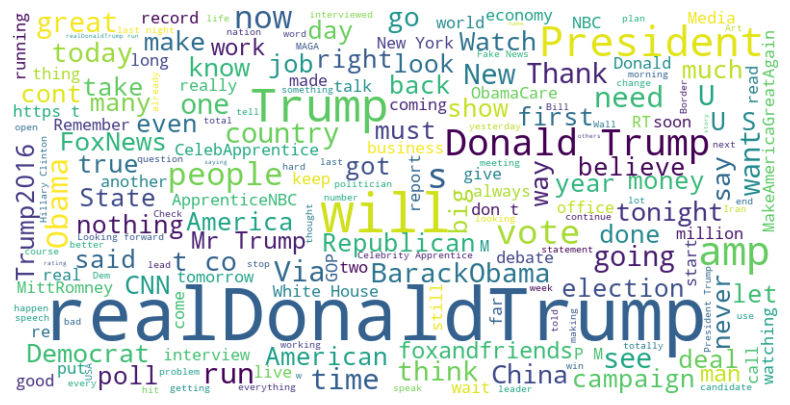

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['neutral'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive and highly positive tweets (in that order)

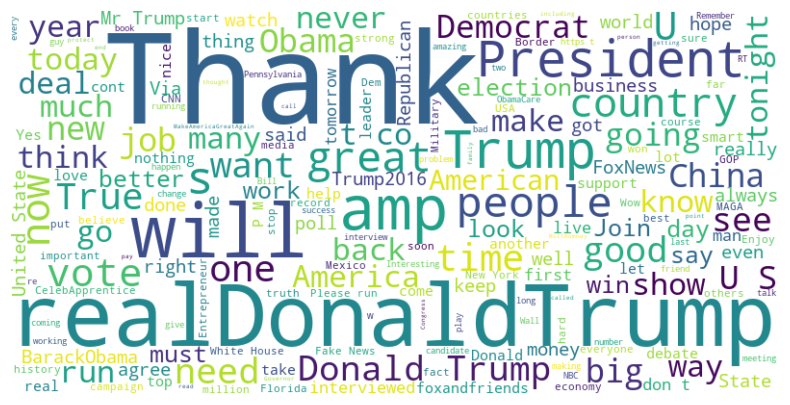

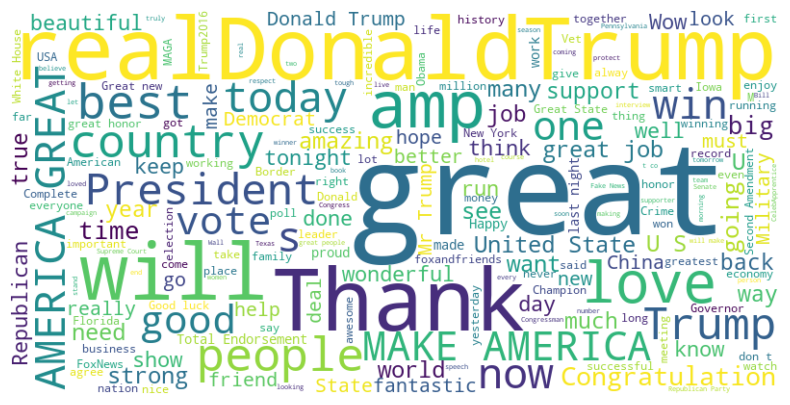

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['positive'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['highly positive'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Negative and highly negative (in that order)

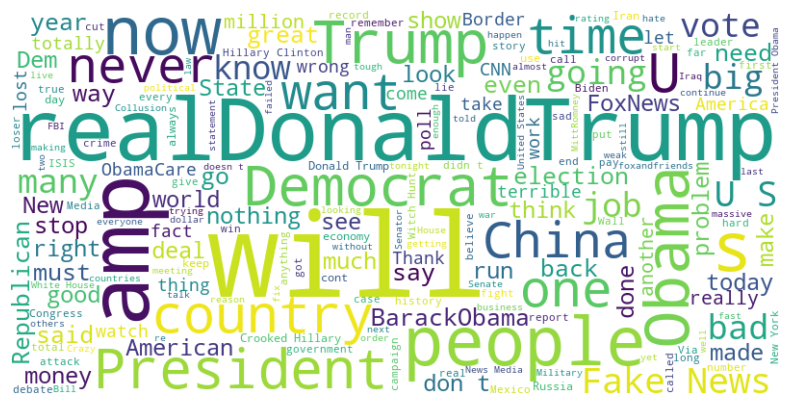

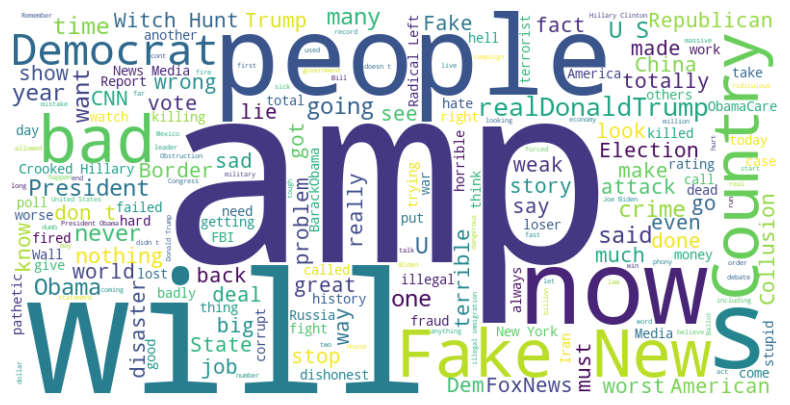

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['negative'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['highly negative'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Modelling and Prediction

Let's take a look at how we began to determine what stocks were most correlated with the sentiment of Donald Trump's tweets. We applied a few different techniques, and our end results give us the most correlated with the two different techniques we've chosen.  
  
The first technique is to compute the correlation of the cummulative sentiment trend to the different variables of the stocks over time. In order to achieve this, some additional post processing is necessary before we can compute a correlation. Let's check out the method we developed to compute this.

In [ ]:
def compute_correlation(company, stock_type, method):
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
    stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

    trump_dates = company_trump['date']
    stock_values = company_stock[['Date', stock_type]]
    missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
    stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
    stock_values = stock_values.sort_values('Date')
    stock_values = stock_values.reset_index(drop=True)
    stock_values[stock_type] = stock_values[stock_type].interpolate()
    stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

    stock_values.dropna(inplace=True)
    company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
    transformed_polarity = company_trump['polarityScaled']
    transformed_adj_close = stock_values[stock_type]

    if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
        return 0, 0

    std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    return std_correlation

Let's break down this method:
1. The method requires the `company` symbol in the stock dataset, the `stock_type` we want to compare a trend against, and the `method` of correlation. For our case, we used Spearmans' correlation as it is a non-parametric test. A non-parametric test works best with our data as our data is not normally distributed. Spearmans does work better with ordinal data, however we did not find any issues with that assumption here.
2. We create a copy of the trump dataset, as we are later going to scale the values to match the stock data. 
```python
trump_2 = trump.copy()
```
3. We get all values in the stock dataset which match the company we chose earlier, and also keep only the stocks which are within the timeframe of the Trump data. This is because the stock data is up to date as of the start of the project, so many dates are too far in the future for what we have with the Trump data.
```python
company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]
```
4. We get the minimum stock value for the chosen stock type, and the maximum. These will be used for the Min/Max scaling.
```python
stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()
```
5. Now we scale the cummulative polarity values to the range of the stock trend. This is necessary as the cummulative data is consistently far larger than the stock data in terms of trend accumulation, so scaling it provides a better chance for the correlation to exist.
```python
scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])
```
6. Now, as it is more important that the dates of the Trump data fit to the dates of the stocks, we trim the Trump data similar to the stock data before where we only keep dates which fall between the timeline of the stock we have. This is necessary as the stocks in the S&P 500 change in and out all the time, so a newer stock added doesn't have the same tracked data to before it was added.
```python
company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]
```
7. Next, we have to do a little bit of filling in some empty data points. Because of how the stock data was collected, the stock changes only are logged at the end of the day. Mean the rows of data are only for one specific day. This means that if a tweet occurs in the middle of the day, there is no corresponding stock datapoint at that time. To fix this, we can linearly interpolate between the days of the stock, filling in the missing dates and times which do exist within the Trump data.
```python
trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]
```
8. Then, we perform some final post-processing to ensure the dates line up correctly before a correlation is computed.
```python
stock_values.dropna(inplace=True)
company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
transformed_polarity = company_trump['polarityScaled']
transformed_adj_close = stock_values[stock_type]
```

9. Lastly, we can check if there is still data left (sometimes there is no overlap between the dates of a stock and the dates of the Trump tweets) and compute our chosen correlation.
```python
if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
    return 0, 0

std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))
```

### Results Analysis

### Citations

1. cjhutto. (2018, December 19). cjhutto/vaderSentiment. GitHub. https://github.com/cjhutto/vaderSentiment
2. Kinyua, J. D., Mutigwe, C., Cushing, D. J., & Poggi, M. (2021). An analysis of the impact of President Trump’s tweets on the DJIA and S&P 500 using machine learning and sentiment analysis. Journal of Behavioral and Experimental Finance, 29, 100447. https://doi.org/10.1016/j.jbef.2020.100447